# Task 1
## Goal
This task applied MLPs and CNNs on two well-known datasets: MNIST and Fashion MNIST. Both datasets contain the same number of 2D images of size 28x28, split into 10 categories; 60.000 images for training and 10.000 for testing. 
The following options were tested:
 
* initializations
* activations
* training algorithms (optimizers)
* hyperparameters
* regularizations (L1, L2, Dropout, no Dropout)
* number and sizes of layers 
* number and sizes of convolutional filters

The purpose of this task is NOT to get the highest accuracy but to gain some practical experience with tuning networks, running multiple experiments and documenting the findings.

We would use the example shown in [keras's github](https://github.com/keras-team/keras/) as the base.


## Methods
### 1 Preliminary
Since our models are not complicated, we assumed initializations and activations would not play a significant role in the models. We tested it on both dataset and both models.

We would use a large batch size, if training is unstable or the final performance is disappointing, then try using a small batch size instead.

### 2 Training algorithms 
Again, since our models are not complicated, we do not think different optimizer will have huge effects on the results. We tested it on both dataset and both models, focusing on the accruray and training time for converging (using early stop).
Recommmendation from [Chengwei Zhang](https://www.dlology.com/blog/quick-notes-on-how-to-choose-optimizer-in-keras/): Use SGD+Nesterov for shallow networks, and either Adam or RMSprop for deepnets.

### 3 Complexity
* Model size vs Regularizations (L1, L2, Dropout, no Dropout) 
* Number and sizes of convolutional filters

In practice, it’s often simpler and more efficient to pick a model with more layers and neurons than you actually need, then ajust the models later.

### 4 Learning Rate
Based on the recommendation from Deep Learning course from Standard Univeristy (taught by Andrew Ng), number and sizes of layers and not as important as learning rate $\alpha$.
Learning rate is the most important hyperparameter
In general, the optimal learning rate is about half of the maximum learning rate (i.e., the learning rate above which the training algorithm diverges. One way is to train the model for a few hundred iterations, starting with a very low learning rate (e.g., 10 -5 ) and gradually increasing it up to a very large value (e.g., 10). The optimal learning rate will be a bit lower than the point at which the loss starts to climb (typically about 10 times lower than the turning point). You can then reinitialize your model and train it normally using this good learning rate.

Since this task focuses on experimenting, we did not use a grid serach for every  expereiment. In practical, we could follow 'Coarse to fine' strategy, i.e. trying random values at first. This way, we can test more options for each parameter. 




## Setup

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras

from keras.datasets import mnist, fashion_mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D,BatchNormalization
from keras.regularizers import l1, l2
from keras.optimizers import SGD, Adadelta, RMSprop, Adam

tf.__version__, keras.__version__, keras.backend.backend()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


('2.2.0-rc3', '2.3.0-tf', 'tensorflow')

We can see that we are using 'tensorflow' as backend. It means we need to use “channels_last” tensors. It will be reflected in the way we code our input.

## Data

In [0]:
(X_train1, y_train1), (X_test1, y_test1) = mnist.load_data()
(X_train2, y_train2), (X_test2, y_test2) = fashion_mnist.load_data()

# Xs normalized to [0, 1]; added color channel (for CNN but never hurts):
X_train1 = X_train1.reshape(*X_train1.shape, 1) / 255.0
X_test1 = X_test1.reshape(*X_test1.shape, 1) / 255.0
X_train2 = X_train2.reshape(*X_train2.shape, 1) / 255.0
X_test2 = X_test2.reshape(*X_test2.shape, 1) / 255.0

# two dataset have the same size
print('X_train shape:', X_train1.shape) 
print('X_test shape:', X_test1.shape)

# Sparse matrices for y:
num_classes = 10
y_train1 = keras.utils.to_categorical(y_train1, num_classes)
y_test1 = keras.utils.to_categorical(y_test1, num_classes)
y_train2 = keras.utils.to_categorical(y_train2, num_classes)
y_test2 = keras.utils.to_categorical(y_test2, num_classes)

4423680/4422102 [==============================] - 2s 1us/step
X_train shape: (60000, 28, 28, 1)
X_test shape: (10000, 28, 28, 1)


In [0]:
batch_size = 128
input_shape = X_train1.shape[1:]

## Base Scenario



In [0]:
def mlp(X_train, y_train, epochs = 10, reg = None, 
        init = 'glorot_uniform' , act = 'relu', opt = RMSprop()):
    model = Sequential([
    Flatten(input_shape=input_shape), 
    Dense(512, activation=act,
          kernel_initializer= init, 
          kernel_regularizer=reg),
    Dropout(.2),
    Dense(512, activation=act,
          kernel_initializer=init,
          kernel_regularizer=reg),
    Dropout(.2),
    Dense(num_classes, activation="softmax",
          kernel_initializer= init,
          kernel_regularizer=reg)])

    # model.summary()
    model.compile(loss='categorical_crossentropy',
                optimizer=opt,
                metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=0.15,
                        verbose=0)
    his = pd.DataFrame(history.history)
    result = his.iloc[-1,[3,1]]
    print('Train acc:{:.3f}; Valid acc: {:.3f}'.format(result[0], result[1]))
    his.plot(figsize=(8,5)) 
    plt.grid(True) 
    plt.xlabel("Epoch")
    plt.show()
    return model

Train acc:0.992; Valid acc: 0.982


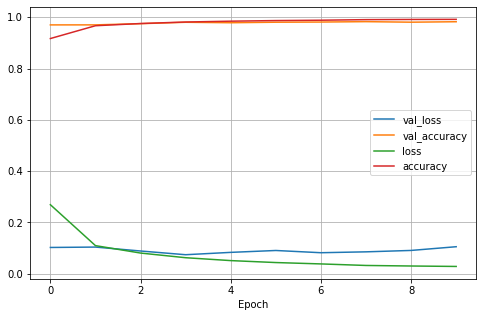

In [0]:
mlp(X_train1, y_train1)

Train acc:0.893; Valid acc: 0.876


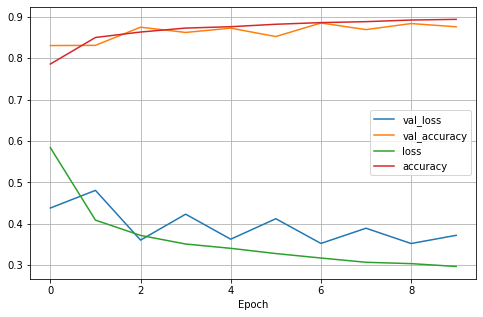

In [0]:
mlp(X_train2, y_train2)

In [0]:
def cnn(X_train, y_train, epochs = 10, reg = None, init = 'glorot_uniform' , 
        act = 'relu',opt = RMSprop()):
    model = Sequential([
    Conv2D(32, kernel_size=(3, 3),
                    activation=act,
                    kernel_initializer= init, 
                    kernel_regularizer=reg,
                    input_shape=input_shape),
    Conv2D(64, (3, 3), activation=act,
          kernel_initializer= init, 
          kernel_regularizer=reg),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation= act,
          kernel_initializer= init, 
          kernel_regularizer=reg),
    Dropout(0.5),
    Dense(num_classes, activation='softmax',
          kernel_initializer= init, 
          kernel_regularizer=reg)])

    model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=opt, metrics=['accuracy'])

    history = model.fit(X_train, y_train,
            batch_size=batch_size,epochs=epochs,
            validation_split=0.15,verbose=0)
    his = pd.DataFrame(history.history)
    result = his.iloc[-1,[3,1]]
    print('Train acc:{:.3f}; Valid acc: {:.3f}'.format(result[0], result[1]))
    his.plot(figsize=(8,5)) 
    plt.grid(True) 
    plt.xlabel("Epoch")
    plt.show()
    return model

Train acc:0.987; Valid acc: 0.990


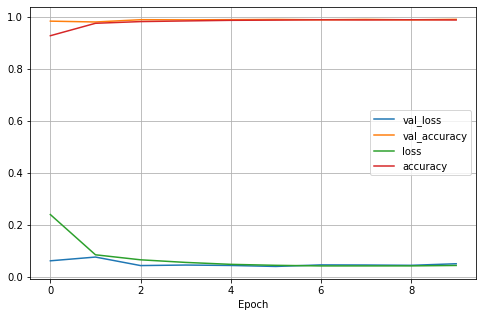

In [0]:
cnn(X_train1, y_train1)

Train acc:0.930; Valid acc: 0.922


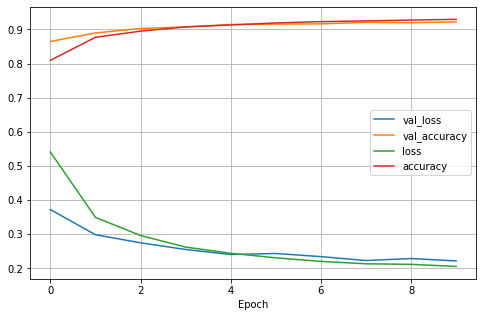

In [0]:
cnn(X_train2, y_train2)

## Prelimnary


### Intitialization

RandomNormal
Train acc:0.992; Valid acc: 0.981


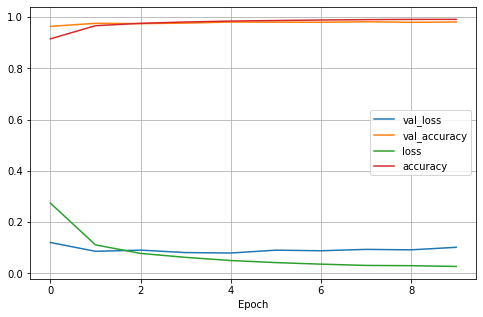

Train acc:0.894; Valid acc: 0.879


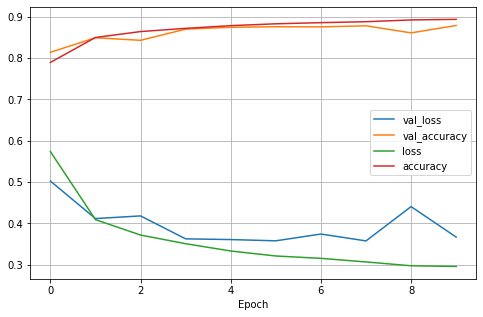

glorot_normal
Train acc:0.992; Valid acc: 0.982


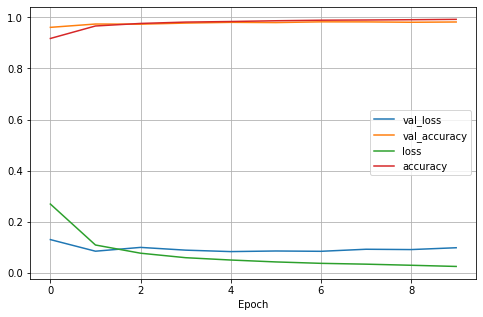

Train acc:0.891; Valid acc: 0.877


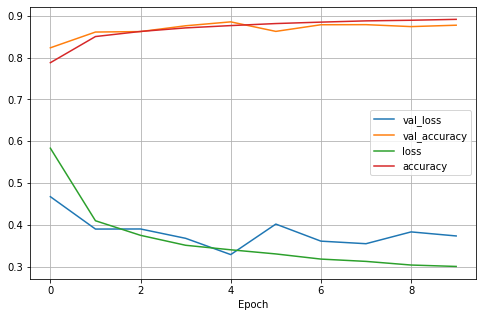

lecun_uniform
Train acc:0.991; Valid acc: 0.979


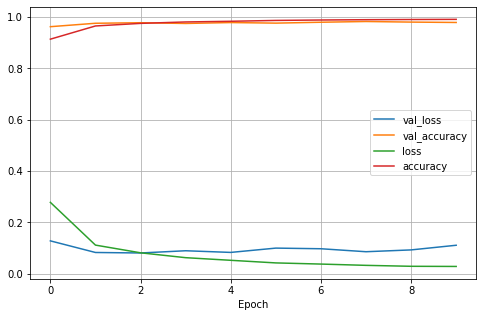

Train acc:0.892; Valid acc: 0.881


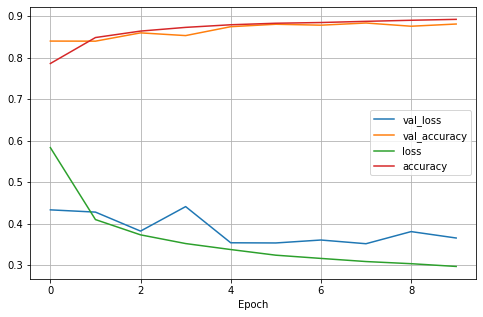

In [0]:
for init in ['RandomNormal','glorot_normal','lecun_uniform']:
    print(init)
    mlp(X_train1, y_train1,init = init )
    mlp(X_train2, y_train2,init = init )

RandomNormal
Train acc:0.987; Valid acc: 0.989


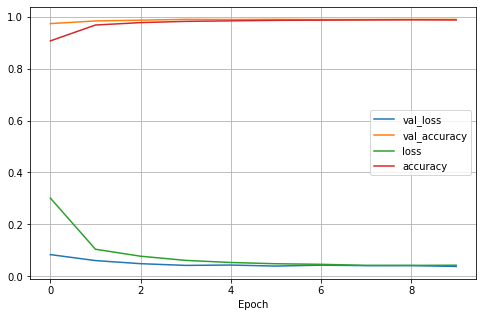

Train acc:0.927; Valid acc: 0.922


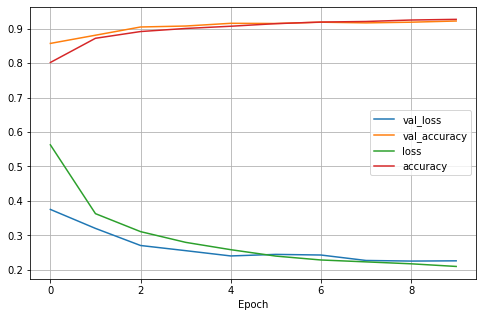

glorot_normal
Train acc:0.987; Valid acc: 0.988


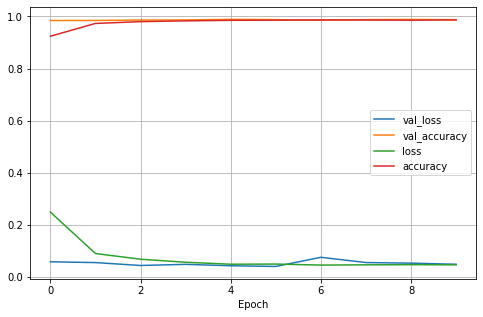

Train acc:0.934; Valid acc: 0.923


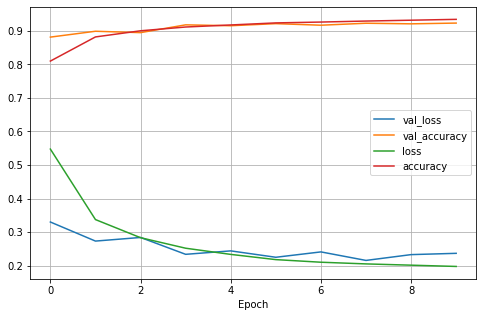

lecun_uniform
Train acc:0.990; Valid acc: 0.990


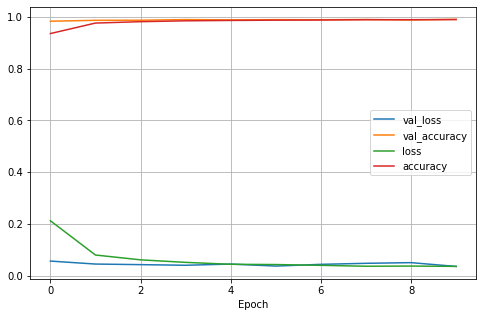

Train acc:0.930; Valid acc: 0.915


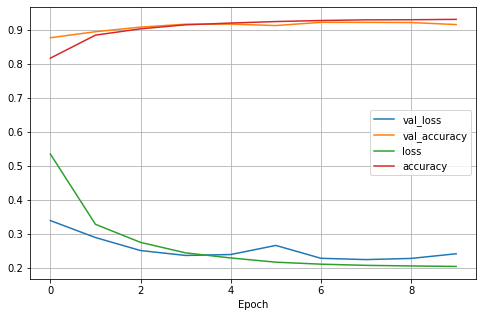

In [0]:
for init in ['RandomNormal','glorot_normal','lecun_uniform']:
    print(init)
    cnn(X_train1, y_train1, epochs = 10, init = init )
    cnn(X_train2, y_train2, epochs = 10, init = init )



### Activation

tanh
Train acc:0.987; Valid acc: 0.978


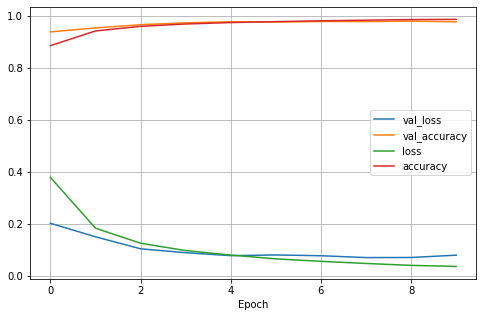

Train acc:0.894; Valid acc: 0.887


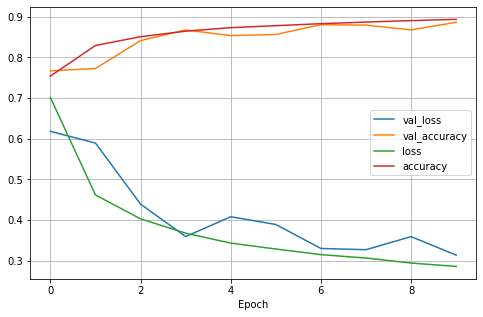

sigmoid
Train acc:0.981; Valid acc: 0.977


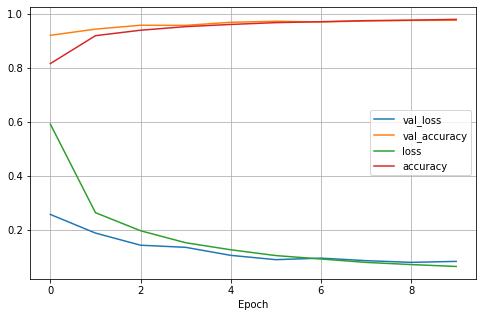

Train acc:0.889; Valid acc: 0.880


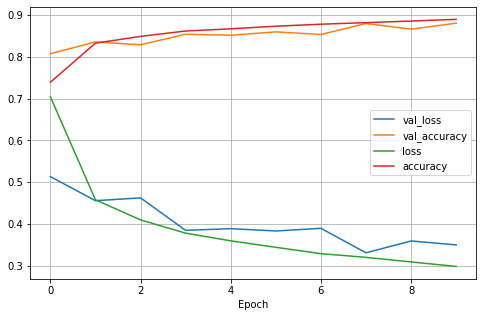

linear
Train acc:0.909; Valid acc: 0.921


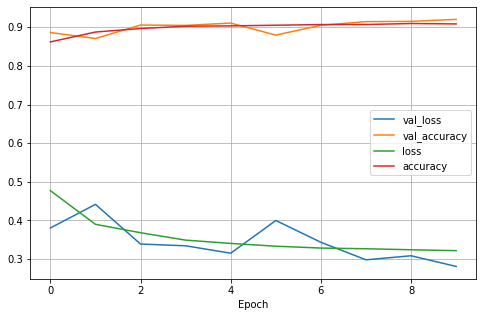

Train acc:0.837; Valid acc: 0.824


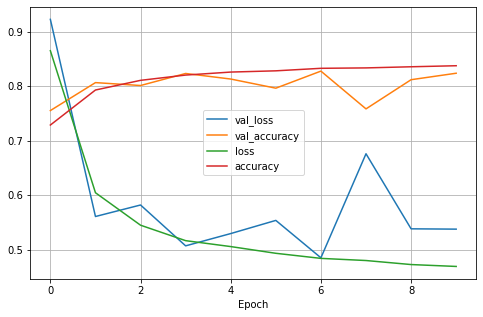

In [0]:
for act in ['tanh','sigmoid','linear']:
    print(act)
    mlp(X_train1, y_train1, epochs = 10, act = act )
    mlp(X_train2, y_train2, epochs = 10, act = act )

tanh
Train acc:0.987; Valid acc: 0.985


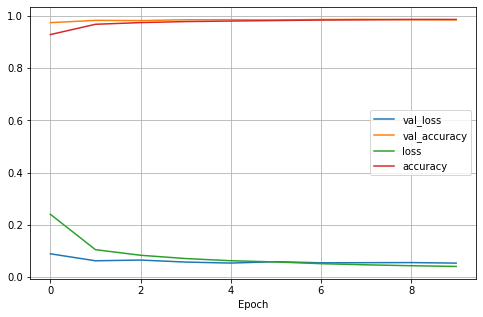

Train acc:0.926; Valid acc: 0.910


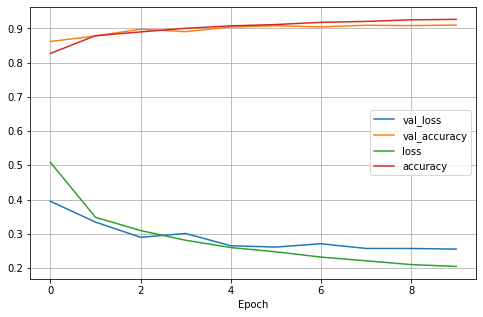

sigmoid
Train acc:0.972; Valid acc: 0.983


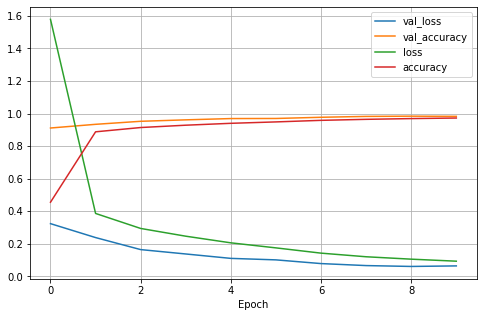

Train acc:0.867; Valid acc: 0.882


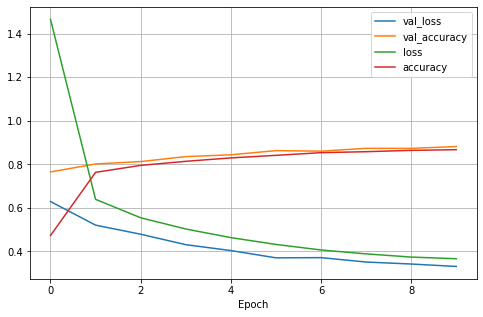

linear
Train acc:0.980; Valid acc: 0.978


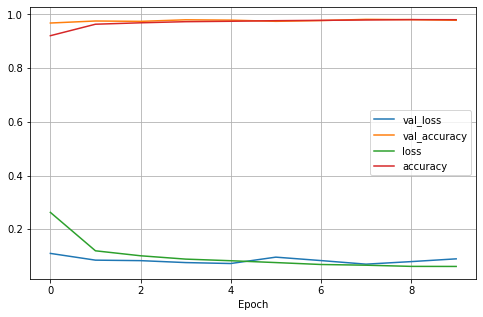

Train acc:0.913; Valid acc: 0.895


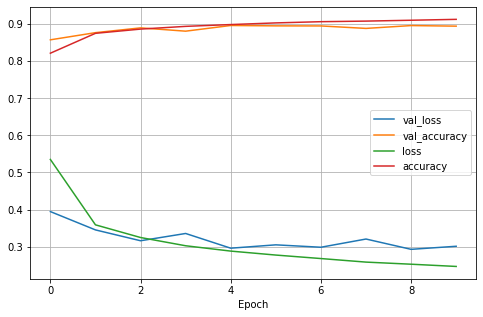

In [0]:
for act in ['tanh','sigmoid','linear']:
    print(act)
    cnn(X_train1, y_train1, epochs = 10, act = act )
    cnn(X_train2, y_train2, epochs = 10, act = act )

### Training algorithms

* SGD(nesterov=True)
* Adam = RMSprop + Momentum
* AdaDelta

Train acc:0.911; Valid acc: 0.907


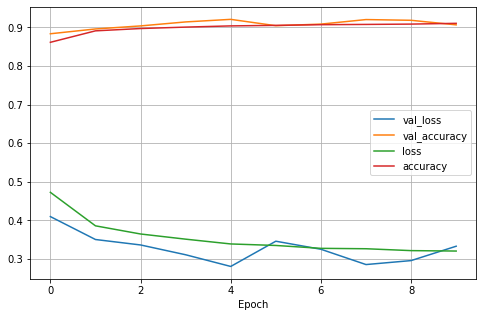

Train acc:0.836; Valid acc: 0.819


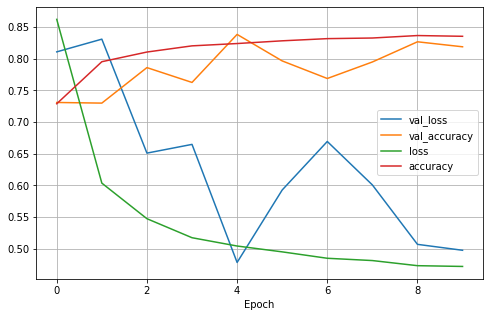

Train acc:0.910; Valid acc: 0.907


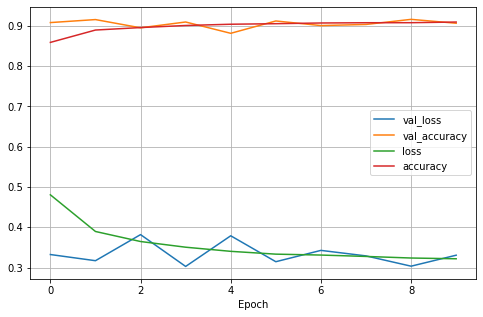

Train acc:0.836; Valid acc: 0.835


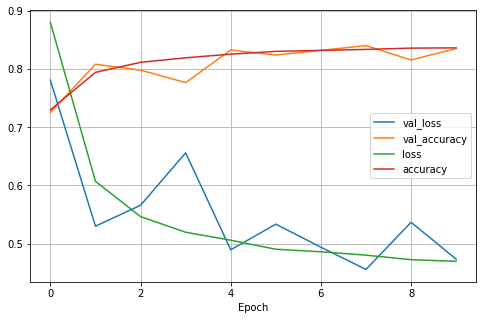

Train acc:0.909; Valid acc: 0.923


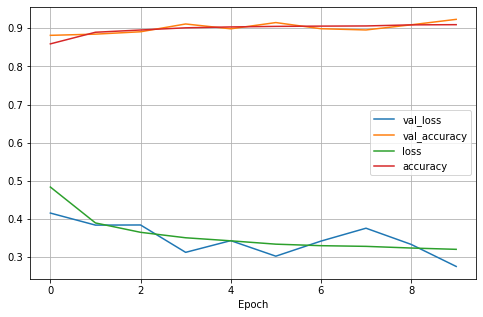

Train acc:0.836; Valid acc: 0.833


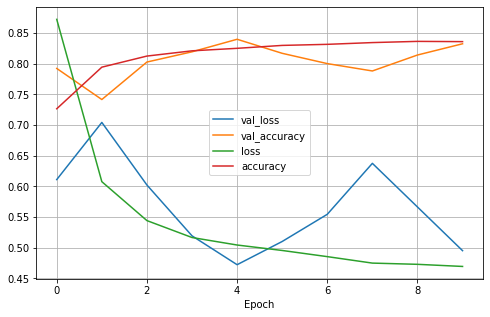

In [0]:
for opt in [SGD(nesterov=True), Adam(), Adadelta()]:
    print(str(opt))
    mlp(X_train1, y_train1,epochs = 10, act = act )
    mlp(X_train2, y_train2,epochs = 10, act = act )

Train acc:0.981; Valid acc: 0.980


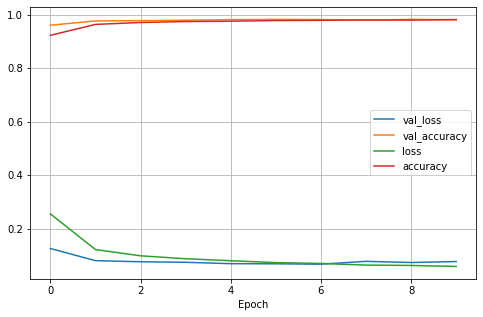

Train acc:0.912; Valid acc: 0.895


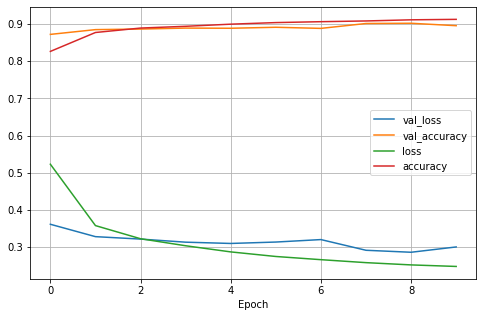

Train acc:0.981; Valid acc: 0.976


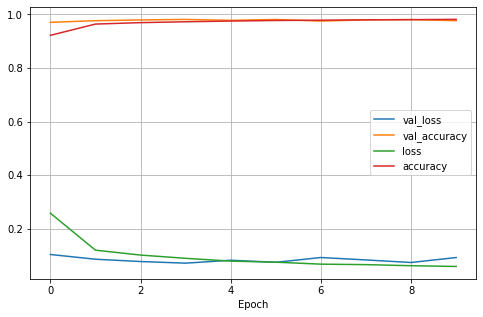

Train acc:0.913; Valid acc: 0.890


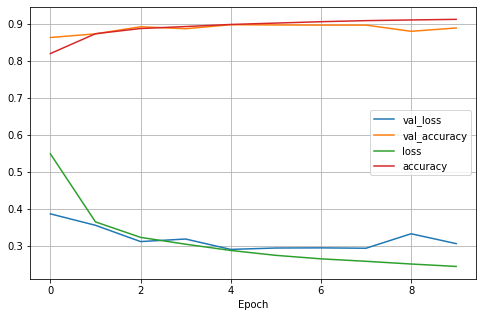

Train acc:0.981; Valid acc: 0.983


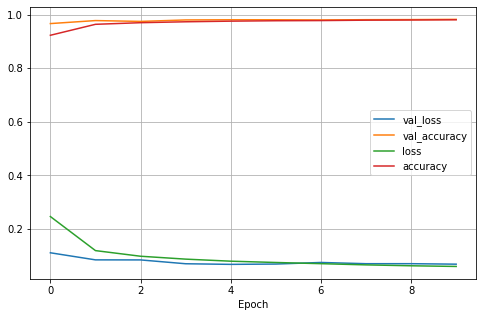

Train acc:0.912; Valid acc: 0.895


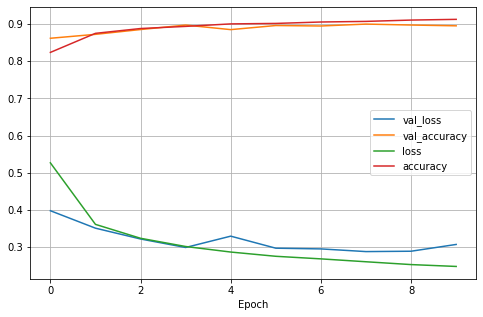

In [0]:
for opt in [SGD(nesterov=True), Adam(), Adadelta()]:
    print(str(opt))
    cnn(X_train1, y_train1, epochs = 10, act = act )
    cnn(X_train2, y_train2, epochs = 10, act = act )

## Complexity

In [0]:
## without dropout
def mlp2(X_train, y_train, epochs = 10, reg = None, init = 'glorot_uniform' , 
         act = 'relu', opt = RMSprop()):
    model = Sequential([
    Flatten(input_shape=input_shape), 
    Dense(512, activation=act,
          kernel_initializer= init, 
          kernel_regularizer=reg),
    Dense(512, activation=act,
          kernel_initializer=init,
          kernel_regularizer=reg),
    Dense(num_classes, activation="softmax",
          kernel_initializer= init,
          kernel_regularizer=reg)])

    # model.summary()
    model.compile(loss='categorical_crossentropy',
                optimizer=opt,metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,validation_split=0.15,
                        verbose=0)
    his = pd.DataFrame(history.history)
    result = his.iloc[-1,[3,1]]
    print('Train acc:{:.3f}; Valid acc: {:.3f}'.format(result[0], result[1]))
    his.plot(figsize=(8,5)) 
    plt.grid(True) 
    plt.xlabel("Epoch")
    plt.show()
    return his

def cnn2(X_train, y_train, epochs = 10,  reg = None, init = 'glorot_uniform' , 
         act = 'relu',opt = RMSprop()):
    model = Sequential([
    Conv2D(32, kernel_size=(3, 3),
                    activation=act,
                    kernel_initializer= init, 
                    kernel_regularizer=reg,
                    input_shape=input_shape),
    Conv2D(64, (3, 3), activation=act,
          kernel_initializer= init, 
          kernel_regularizer=reg),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation= act,
          kernel_initializer= init, 
          kernel_regularizer=reg),
    Dense(num_classes, activation='softmax',
          kernel_initializer= init, 
          kernel_regularizer=reg)])

    model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=opt, metrics=['accuracy'])

    history = model.fit(X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_split=0.15,verbose=0)
    his = pd.DataFrame(history.history)
    result = his.iloc[-1,[3,1]]
    print('Train acc:{:.3f}; Valid acc: {:.3f}'.format(result[0], result[1]))
    his.plot(figsize=(8,5)) 
    plt.grid(True) 
    plt.xlabel("Epoch")
    plt.show()
    return his

### Without dropout

Train acc:0.996; Valid acc: 0.978


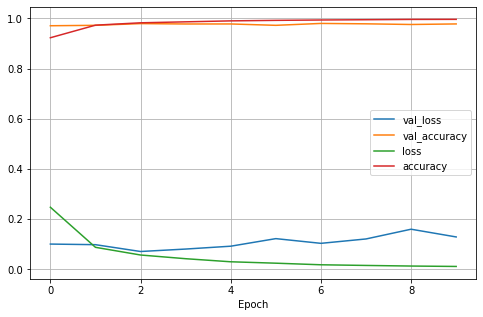

Train acc:0.911; Valid acc: 0.864


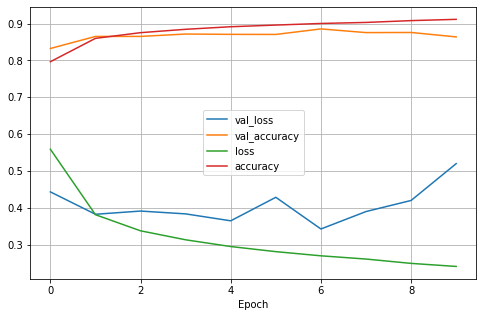

,val_loss,val_accuracy,loss,accuracy
0,0.443019,0.832222,0.558830,0.796274
1,0.382263,0.864889,0.381066,0.859706
2,0.390983,0.865000,0.337349,0.875137
3,0.383315,0.871444,0.312971,0.884274
4,0.364514,0.870556,0.294671,0.891255
5,0.428315,0.870333,0.280821,0.895765
6,0.342315,0.885333,0.269499,0.900118
7,0.389632,0.875333,0.260722,0.902922
8,0.419727,0.875667,0.248960,0.907863
9,0.519678,0.863667,0.240650,0.911274


In [0]:
mlp2(X_train1, y_train1)
mlp2(X_train2, y_train2)

Train acc:0.999; Valid acc: 0.990


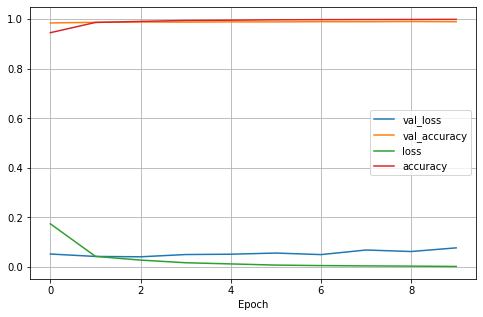

Train acc:0.988; Valid acc: 0.925


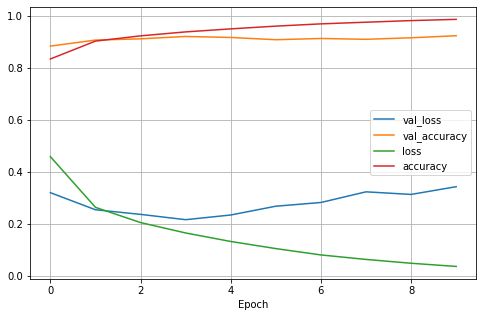

,val_loss,val_accuracy,loss,accuracy
0,0.321339,0.884778,0.459800,0.835333
1,0.255674,0.908000,0.264911,0.904020
2,0.237917,0.912778,0.206391,0.924176
3,0.217476,0.921889,0.166439,0.939412
4,0.235501,0.918000,0.133739,0.951020
5,0.269295,0.909333,0.106379,0.961588
6,0.283622,0.914111,0.081956,0.970275
7,0.324576,0.910889,0.064704,0.976667
8,0.314570,0.916778,0.049993,0.982843
9,0.344314,0.924667,0.037730,0.987627


In [0]:
cnn2(X_train1, y_train1)
cnn2(X_train2, y_train2)

### Adding reguarization

Train acc:0.113; Valid acc: 0.106


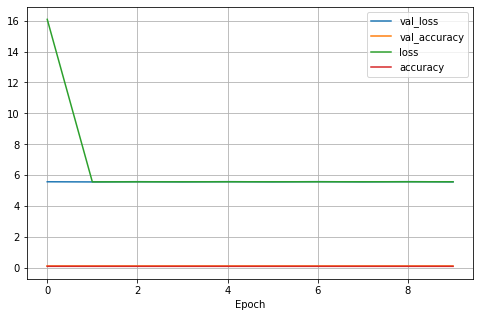

Train acc:0.099; Valid acc: 0.097


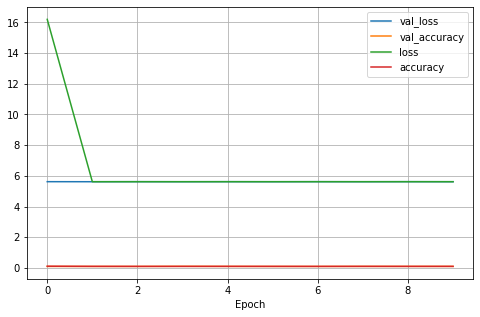

Train acc:0.113; Valid acc: 0.106


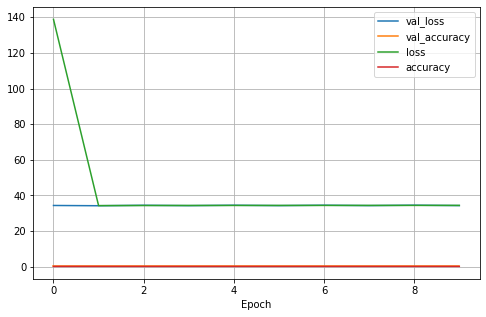

Train acc:0.099; Valid acc: 0.097


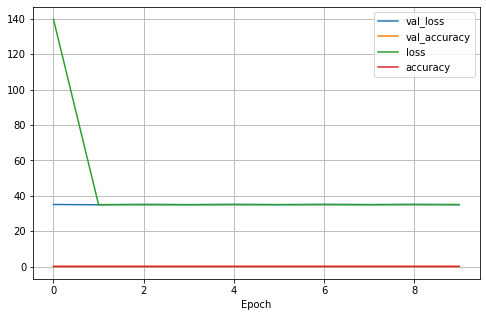

Train acc:0.892; Valid acc: 0.906


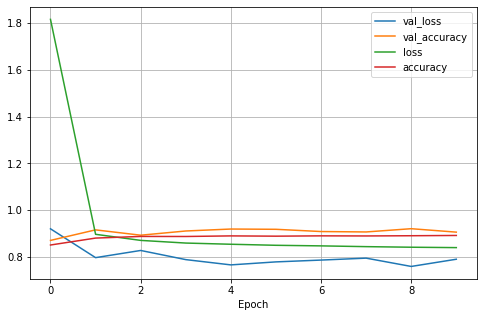

Train acc:0.783; Valid acc: 0.755


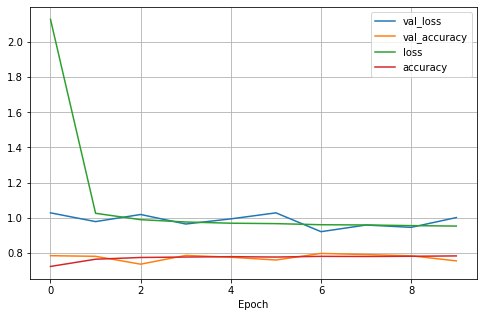

Train acc:0.394; Valid acc: 0.395


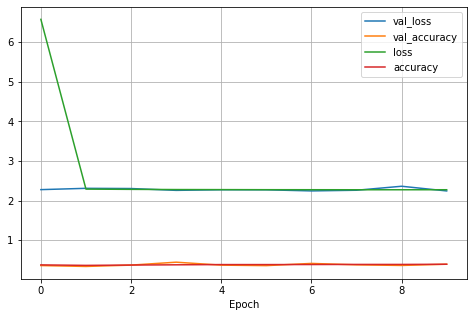

Train acc:0.451; Valid acc: 0.455


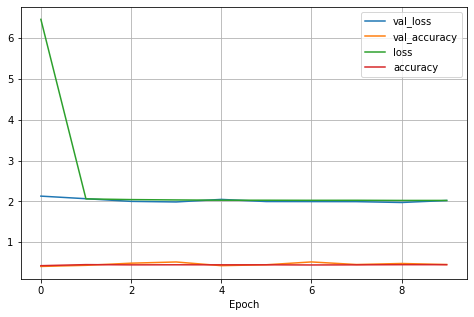

In [0]:
for reg in [l1(0.01),l1(0.1),l2(0.01),l2(0.1)]:
    print(reg)
    mlp(X_train1, y_train1,epochs = 10, reg = reg )
    mlp(X_train2, y_train2,epochs = 10, reg = reg )

Train acc:0.113; Valid acc: 0.106


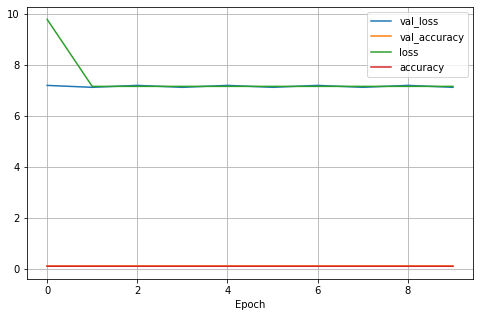

Train acc:0.100; Valid acc: 0.099


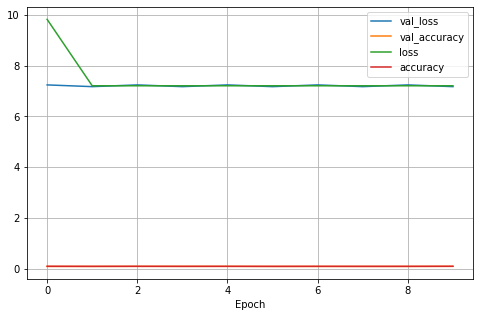

Train acc:0.113; Valid acc: 0.106


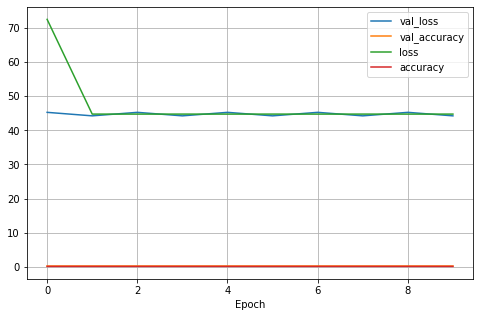

Train acc:0.099; Valid acc: 0.097


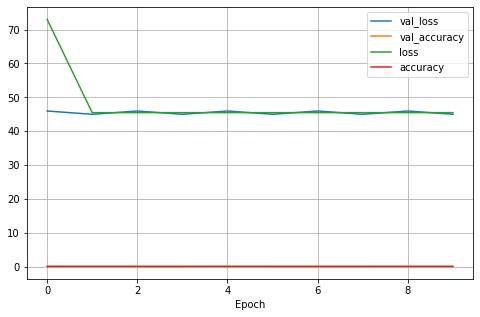

Train acc:0.931; Valid acc: 0.965


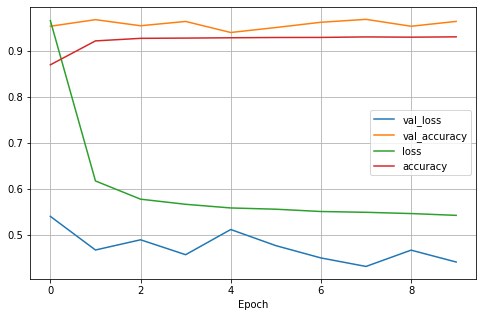

Train acc:0.822; Valid acc: 0.837


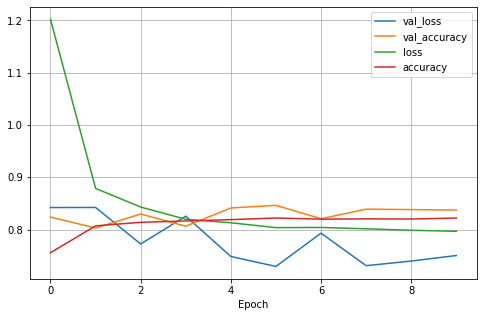

Train acc:0.774; Valid acc: 0.852


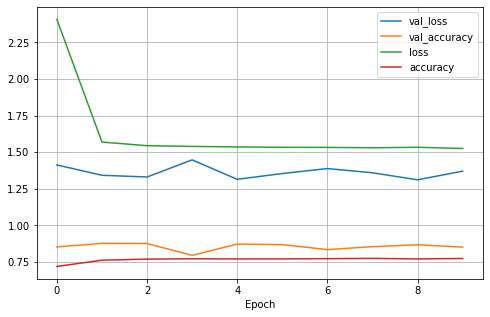

Train acc:0.640; Valid acc: 0.707


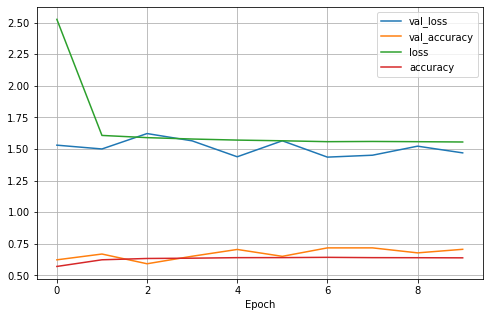

In [0]:
for reg in [l1(0.01),l1(0.1),l2(0.01),l2(0.1)]:
    print(reg)
    cnn(X_train1, y_train1, epochs = 10, reg = reg )
    cnn(X_train2, y_train2, epochs = 10, reg = reg )

### Layers for cnn

In [0]:
def layers(n_hidden = 1, n_neurons = 30):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                    activation=act,
                    kernel_initializer= init, 
                    kernel_regularizer=reg,
                    input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(n_neurons, activation= 'relu'))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=RMSprop(),
                metrics=['accuracy'])
    return model


keras_reg = keras.wrappers.scikit_learn.KerasRegressor(layers)
#keras_reg.fit(X_train1,y_train1,epochs=10, validation_split=0.15)

In [0]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    'n_hidden' : [1,2],
    'n_neurons' : [10,100,500]}

rnd_serach_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter = 10, cv =3, verbose=0)
rnd_serach_cv.fit(X_train1, y_train1, epochs = 10, validation_split=0.15)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


Train on 34000 samples, validate on 6000 samples
Epoch 1/10
34000/34000 [==============================] - 6s 163us/step - loss: 0.7440 - accuracy: 0.9080 - val_loss: 0.1594 - val_accuracy: 0.9632
Epoch 2/10
34000/34000 [==============================] - 5s 158us/step - loss: 0.1254 - accuracy: 0.9683 - val_loss: 0.0790 - val_accuracy: 0.9813
Epoch 3/10
34000/34000 [==============================] - 5s 159us/step - loss: 0.0911 - accuracy: 0.9764 - val_loss: 0.0679 - val_accuracy: 0.9825
Epoch 4/10
34000/34000 [==============================] - 5s 159us/step - loss: 0.0754 - accuracy: 0.9804 - val_loss: 0.0652 - val_accuracy: 0.9840
Epoch 5/10
34000/34000 [==============================] - 5s 159us/step - loss: 0.0656 - accuracy: 0.9826 - val_loss: 0.0564 - val_accuracy: 0.9855
Epoch 6/10
34000/34000 [==============================] - 5s 159us/step - loss: 0.0573 - accuracy: 0.9850 - val_loss: 0.0678 - val_accuracy: 0.9842
Epoch 7/10
34000/34000 [==============================] - 5s 15

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f9155490160>,
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'n_hidden': [1, 2],
                                        'n_neurons': [10, 100, 500]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [0]:
print(pd.DataFrame(rnd_serach_cv.cv_results_))

   mean_fit_time  std_fit_time  ...  std_test_score  rank_test_score
0      55.858739      0.340168  ...        0.022196                5
1      55.837019      0.109907  ...        0.006464                3
2      65.121343      0.484523  ...        0.009671                6
3      60.192370      0.602052  ...        0.005523                1
4      60.893611      0.230418  ...        0.011961                2
5      61.730027      0.715469  ...        0.017738                4

[6 rows x 13 columns]


In [0]:
print(rnd_serach_cv.best_params_)

{'n_neurons': 10, 'n_hidden': 2}


In [0]:
'''
# for test data
from sklearn.metrics import accuracy_score
(_, y_train3), (_, y_test3) = mnist.load_data()
accuracy_score(y_test3,keras_reg.predict(X_test1).argmax(axis=-1))
'''

'\n# for test data\nfrom sklearn.metrics import accuracy_score\n(_, y_train3), (_, y_test3) = mnist.load_data()\naccuracy_score(y_test3,keras_reg.predict(X_test1).argmax(axis=-1))\n'

## Learning Rate


In [0]:
def mlp3(X_train, y_train, epochs = 10, reg = None, init = 'glorot_uniform' , 
         act = 'relu', lr = 0.001):
    model = Sequential([
    Flatten(input_shape=input_shape), 
    Dense(512, activation=act,
          kernel_initializer= init, 
          kernel_regularizer=reg),
    Dropout(.2),
    Dense(512, activation=act,
          kernel_initializer=init,
          kernel_regularizer=reg),
    Dropout(.2),
    Dense(num_classes, activation="softmax",
          kernel_initializer= init,
          kernel_regularizer=reg)])

    # model.summary()
    model.compile(loss='categorical_crossentropy',
                optimizer=RMSprop(learning_rate=lr),
                metrics=['accuracy'])

    history = model.fit(X_train, y_train,
                        batch_size=batch_size,epochs=epochs,
                        validation_split=0.15,verbose=0)
    his = pd.DataFrame(history.history)
    result = his.iloc[-1,[3,1]]
    print('Train acc:{:.3f}; Valid acc: {:.3f}'.format(result[0], result[1]))
    his.plot(figsize=(8,5)) 
    plt.grid(True) 
    plt.xlabel("Epoch")
    plt.show()
    return his


def cnn3(X_train, y_train, epochs = 10, reg = None, init = 'glorot_uniform' , 
         act = 'relu', lr = 0.001):
    model = Sequential([
    Conv2D(32, kernel_size=(3, 3),
                    activation=act,
                    kernel_initializer= init, 
                    kernel_regularizer=reg,
                    input_shape=input_shape),
    Conv2D(64, (3, 3), activation=act,
          kernel_initializer= init, 
          kernel_regularizer=reg),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),
    Flatten(),
    Dense(128, activation= act,
          kernel_initializer= init, 
          kernel_regularizer=reg),
    Dropout(0.5),
    Dense(num_classes, activation='softmax',
          kernel_initializer= init, 
          kernel_regularizer=reg)])

    model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=RMSprop(learning_rate=lr),
                metrics=['accuracy'])

    history = model.fit(X_train, y_train,
            batch_size=batch_size,epochs=epochs,
            validation_split=0.15,  verbose=0)
    his = pd.DataFrame(history.history)
    result = his.iloc[-1,[3,1]]
    print('Train acc:{:.3f}; Valid acc: {:.3f}'.format(result[0], result[1]))
    his.plot(figsize=(8,5)) 
    plt.grid(True) 
    plt.xlabel("Epoch")
    plt.show()
    return his

0.0001
Train acc:0.977; Valid acc: 0.976


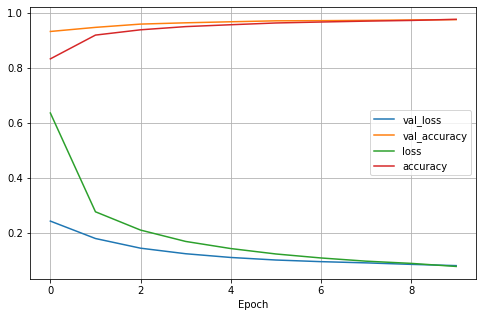

Train acc:0.889; Valid acc: 0.879


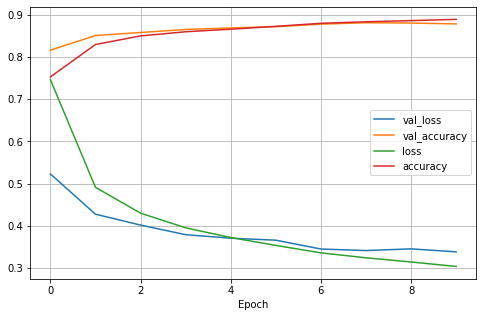

0.005
Train acc:0.972; Valid acc: 0.979


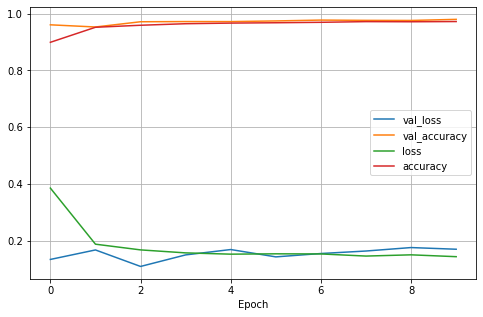

Train acc:0.847; Valid acc: 0.857


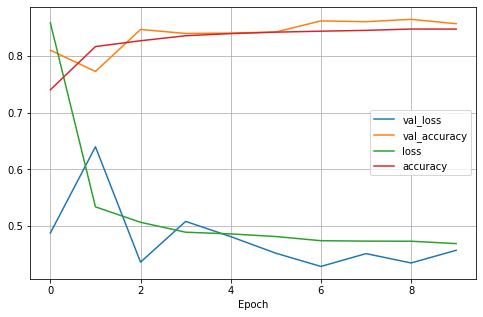

0.01
Train acc:0.949; Valid acc: 0.966


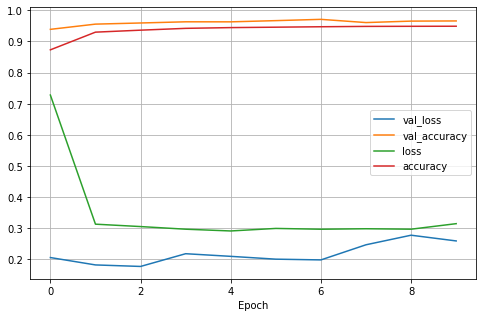

Train acc:0.816; Valid acc: 0.829


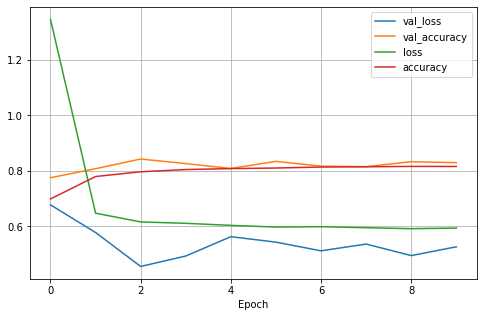

0.1
Train acc:0.292; Valid acc: 0.285


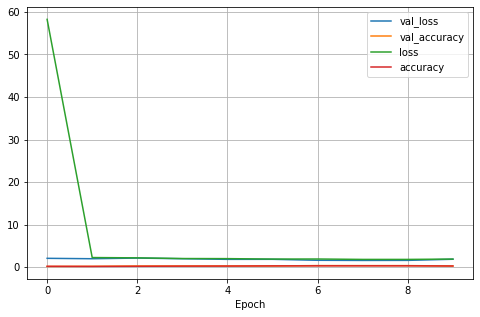

Train acc:0.191; Valid acc: 0.165


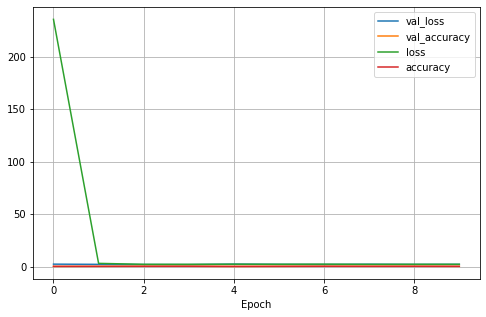

1
Train acc:0.102; Valid acc: 0.101


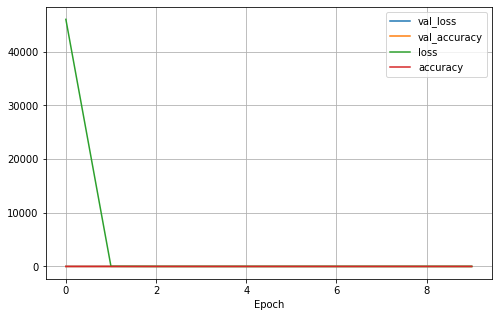

Train acc:0.099; Valid acc: 0.100


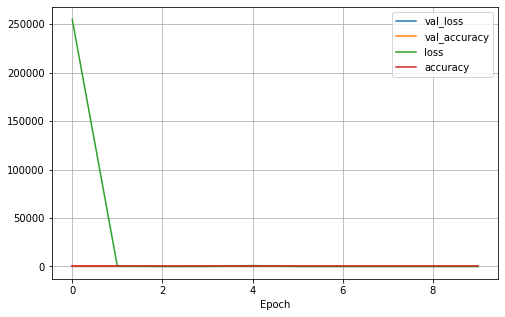

In [0]:
for lr in [0.0001, 0.005, 0.01,  0.1, 1]:
    print(lr)
    mlp3(X_train1, y_train1, epochs = 10, lr = lr )
    mlp3(X_train2, y_train2, epochs = 10, lr = lr )

0.0001
Train acc:0.976; Valid acc: 0.986


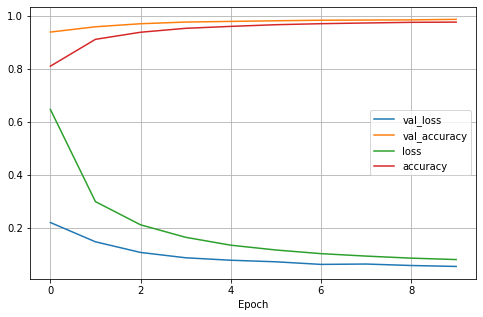

Train acc:0.888; Valid acc: 0.896


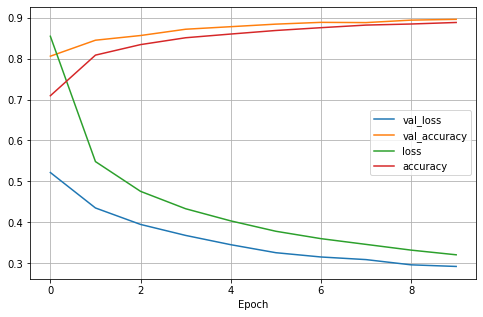

0.005
Train acc:0.980; Valid acc: 0.986


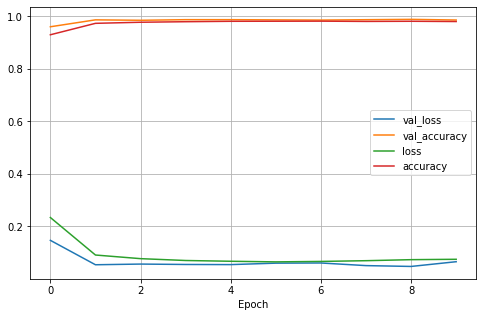

Train acc:0.899; Valid acc: 0.909


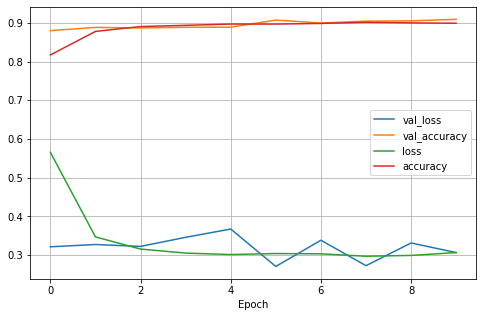

0.01
Train acc:0.968; Valid acc: 0.985


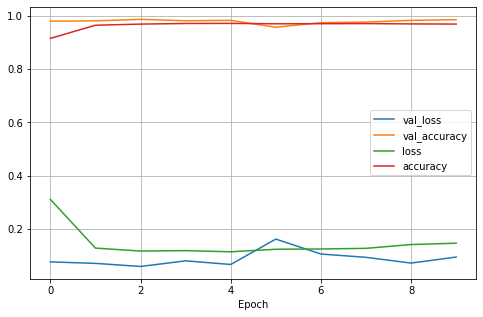

Train acc:0.863; Valid acc: 0.888


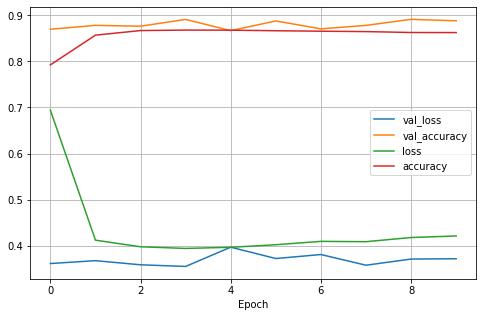

0.1
Train acc:0.105; Valid acc: 0.099


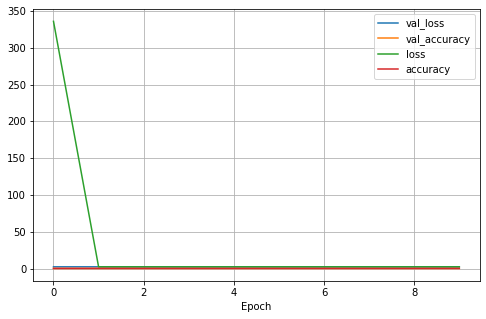

Train acc:0.100; Valid acc: 0.097


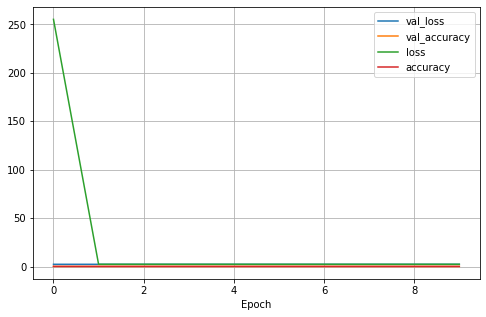

1
Train acc:0.100; Valid acc: 0.100


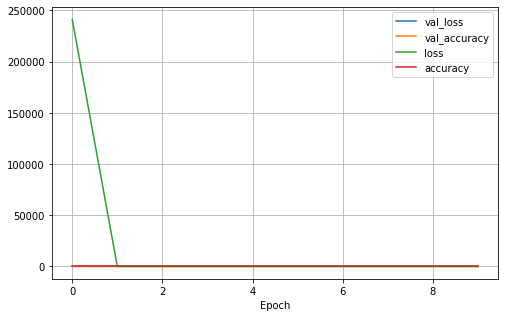

Train acc:0.102; Valid acc: 0.100


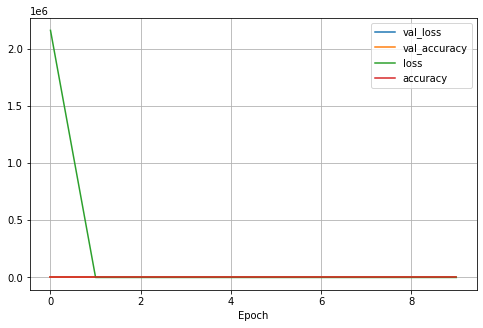

In [0]:
for lr in [0.0001, 0.005, 0.01,  0.1, 1]:
    print(lr)
    cnn3(X_train1, y_train1, epochs = 10, lr = lr )
    cnn3(X_train2, y_train2, epochs = 10, lr = lr )

## Random Walk 


In [0]:
def mlp_digit(X_train, y_train, epochs = 10, init = 'glorot_uniform' , lr = 0.001):
    model = Sequential([
    Flatten(input_shape=input_shape), 
    Dense(1024, activation='relu', kernel_initializer= init),
    BatchNormalization(),
    Dropout(0.1),
    Dense(524, activation='relu', kernel_initializer=init),
    Dense(num_classes, activation="softmax", kernel_initializer= init)])

    # model.summary()
    model.compile(loss='categorical_crossentropy',
                optimizer=RMSprop(learning_rate=lr),
                metrics=['accuracy'])

    history = model.fit(X_train, y_train, 
                        batch_size=batch_size,
                        epochs=epochs, 
                        validation_split=0.15, 
                        verbose=0)
    his = pd.DataFrame(history.history)
    result = his.iloc[-1,[3,1]]
    print('Train acc:{:.3f}; Valid acc: {:.3f}'.format(result[0], result[1]))
    his.plot(figsize=(8,5)) 
    plt.grid(True) 
    plt.xlabel("Epoch")
    plt.show()
    return model

def mlp_fashion(X_train, y_train, epochs = 10, init = 'glorot_uniform' , lr = 0.0001):
    model = Sequential([
    Flatten(input_shape=input_shape), 
    Dense(1024, activation='relu', kernel_initializer= init),
    BatchNormalization(),
    Dense(524, activation='relu',kernel_initializer=init),
    Dropout(0.1),
    Dense(524, activation='relu', kernel_initializer=init),
    Dense(num_classes, activation="softmax",
          kernel_initializer= init)])

    # model.summary()
    model.compile(loss='categorical_crossentropy',
                optimizer=RMSprop(learning_rate=lr),
                metrics=['accuracy'])

    history = model.fit(X_train, y_train, 
                        batch_size=batch_size,
                        epochs=epochs, 
                        validation_split=0.15, 
                        verbose=0)
    his = pd.DataFrame(history.history)
    result = his.iloc[-1,[3,1]]
    print('Train acc:{:.3f}; Valid acc: {:.3f}'.format(result[0], result[1]))
    his.plot(figsize=(8,5)) 
    plt.grid(True) 
    plt.xlabel("Epoch")
    plt.show()
    return model

Train acc:0.993; Valid acc: 0.982


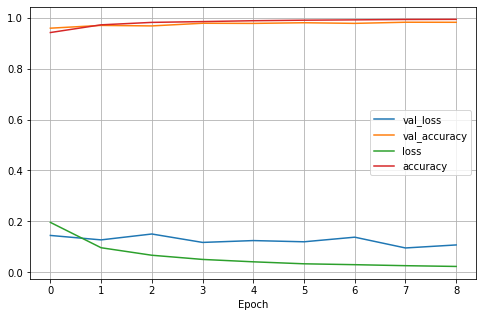

Train acc:0.946; Valid acc: 0.887


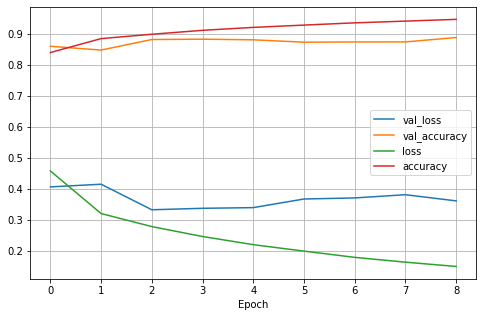

In [0]:
mlp_digit(X_train1,y_train1,epochs = 9)
mlp_fashion(X_train2,y_train2,epochs = 9)

In [0]:
def cnn_digit(X_train, y_train, epochs = 10, init = 'glorot_uniform' , lr = 0.001):
    model = Sequential([
    Conv2D(32, kernel_size=(3, 3),activation='relu',
               kernel_initializer= init, input_shape=input_shape),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer= init),
    Conv2D(64, (3, 3), activation='relu', kernel_initializer= init),
    BatchNormalization(),
    Dropout(0.1),

    Conv2D(64, (3, 3), activation='relu', kernel_initializer= init),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation= 'relu', kernel_initializer= init),
    Dense(num_classes, activation='softmax',kernel_initializer= init)])

    model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=RMSprop(learning_rate=lr), metrics=['accuracy'])

    history = model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,
              validation_split=0.15,verbose=0)
    his = pd.DataFrame(history.history)
    result = his.iloc[-1,[3,1]]
    print('Train acc:{:.3f}; Valid acc: {:.3f}'.format(result[0], result[1]))
    his.plot(figsize=(8,5)) 
    plt.grid(True) 
    plt.xlabel("Epoch")
    plt.show()
    return model

def cnn_fashion(X_train, y_train, epochs = 10, init = 'glorot_uniform', lr = 0.001):
    model = Sequential([
    Conv2D(64, kernel_size=(3, 3),activation='relu',
               kernel_initializer= init, input_shape=input_shape),
    BatchNormalization(),
    Conv2D(64, kernel_size=(3, 3),activation='relu',
               kernel_initializer= init, input_shape=input_shape),
    BatchNormalization(),
    Dropout(0.1),

    Conv2D(64, kernel_size=(3, 3),activation='relu',
               kernel_initializer= init, input_shape=input_shape),
    BatchNormalization(),   
    Conv2D(32, (3, 3), activation='relu',kernel_initializer= init),
    MaxPooling2D(pool_size=(2, 2)),
    BatchNormalization(),
    Dropout(0.1),
    Flatten(),
    Dense(128, activation= 'relu', kernel_initializer= init),
    Dropout(0.1),
    Dense(num_classes, activation='softmax',kernel_initializer= init)])

    model.compile(loss=keras.losses.categorical_crossentropy,
                optimizer=RMSprop(learning_rate=lr), metrics=['accuracy'])

    history = model.fit(X_train, y_train, batch_size=batch_size,epochs=epochs,
              validation_split=0.15,verbose=0)
    his = pd.DataFrame(history.history)
    result = his.iloc[-1,[3,1]]
    print('Train acc:{:.3f}; Valid acc: {:.3f}'.format(result[0], result[1]))
    his.plot(figsize=(8,5)) 
    plt.grid(True) 
    plt.xlabel("Epoch")
    plt.show()
    return model

Train acc:0.999; Valid acc: 0.986


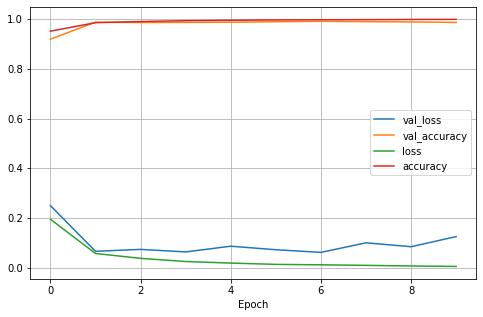

Train acc:0.976; Valid acc: 0.923


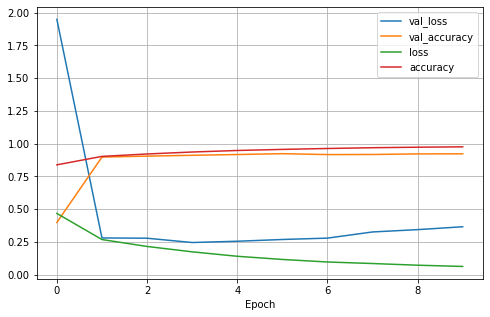

In [0]:
cnn_digit(X_train1,y_train1,epochs = 10)
cnn_fashion(X_train2,y_train2,epochs = 10)

## Retune Learning Rate
Now we have selected our models, we need to retune the learning rate since we have changed the parameters and settings.

0.0001
Train acc:0.999; Valid acc: 0.982


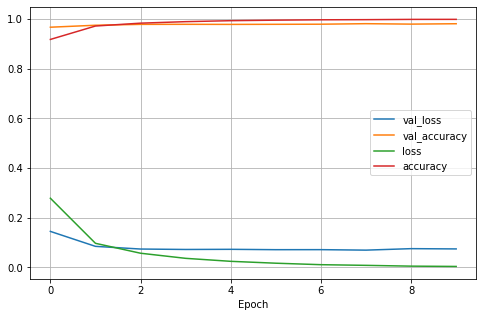

Train acc:0.951; Valid acc: 0.888


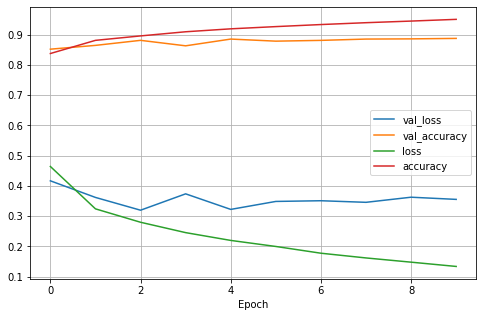

0.005
Train acc:0.985; Valid acc: 0.975


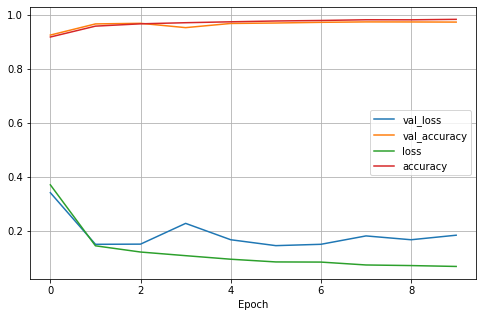

Train acc:0.880; Valid acc: 0.848


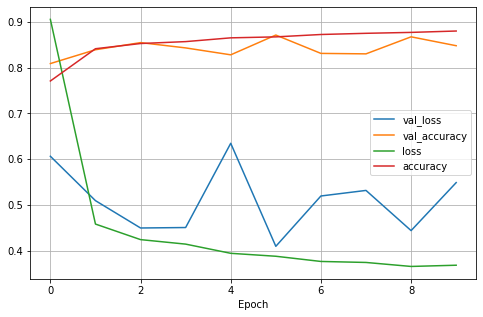

0.01
Train acc:0.976; Valid acc: 0.974


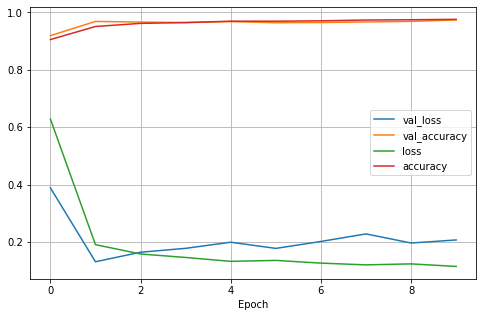

Train acc:0.862; Valid acc: 0.849


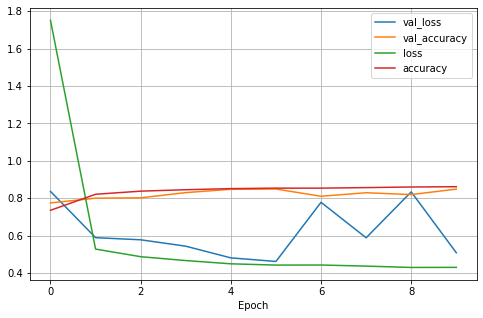

0.1
Train acc:0.190; Valid acc: 0.204


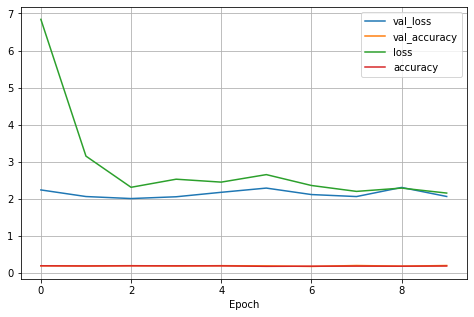

Train acc:0.099; Valid acc: 0.103


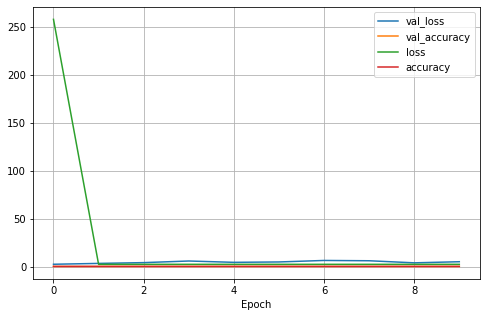

In [0]:
for lr in [0.0001, 0.005, 0.01,  0.1]:
    print(lr)
    mlp_digit(X_train1, y_train1,epochs = 10, lr = lr )
    mlp_fashion(X_train2, y_train2,epochs = 10, lr = lr )

0.0001
Train acc:1.000; Valid acc: 0.991


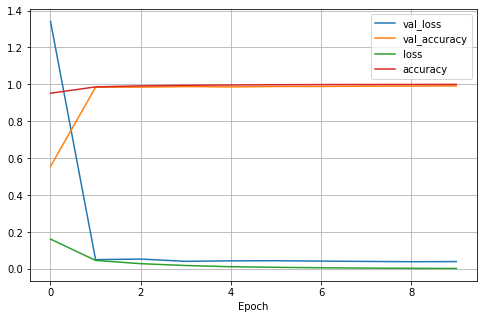

Train acc:0.951; Valid acc: 0.920


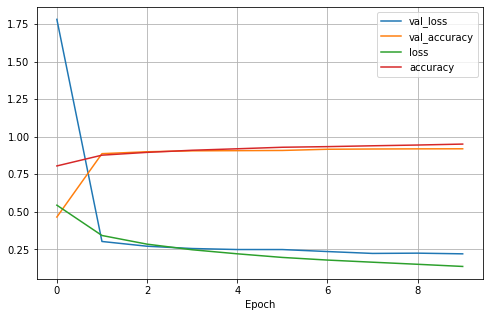

0.005
Train acc:0.996; Valid acc: 0.989


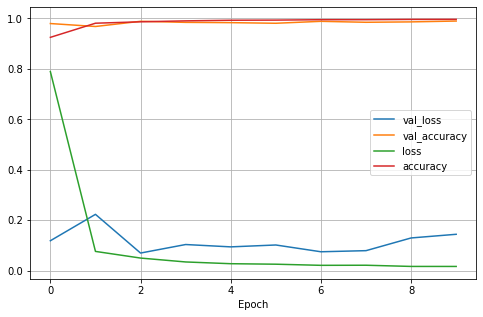

Train acc:0.953; Valid acc: 0.912


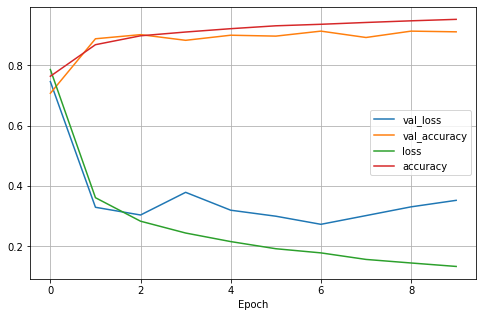

0.01
Train acc:0.993; Valid acc: 0.985


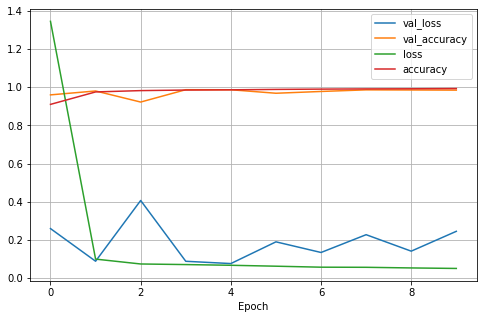

Train acc:0.921; Valid acc: 0.909


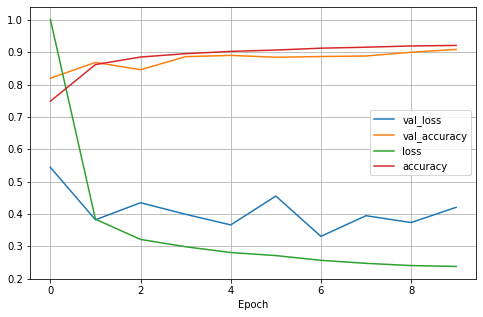

0.1
Train acc:0.106; Valid acc: 0.096


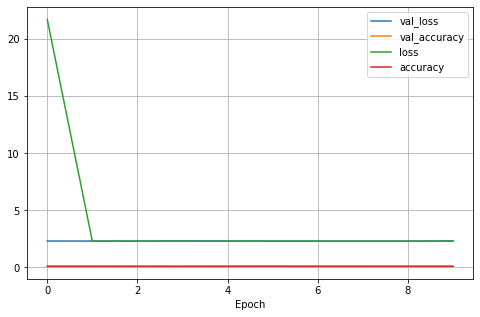

Train acc:0.100; Valid acc: 0.103


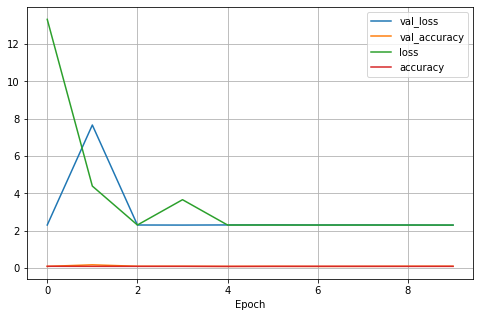

In [0]:
for lr in [0.0001, 0.005, 0.01,  0.1]:
    print(lr)
    cnn_digit(X_train1, y_train1,epochs = 10, lr = lr )
    cnn_fashion(X_train2, y_train2,epochs = 10, lr = lr )

## Test on the test set

Digit data:
Train acc:0.991; Valid acc: 0.980


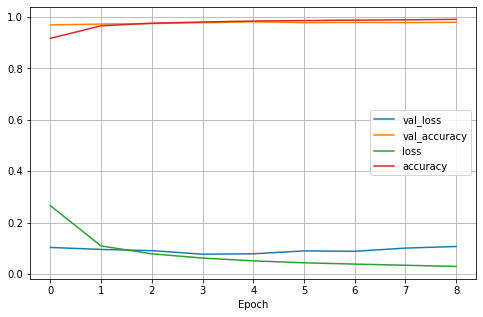

Train acc:0.986; Valid acc: 0.989


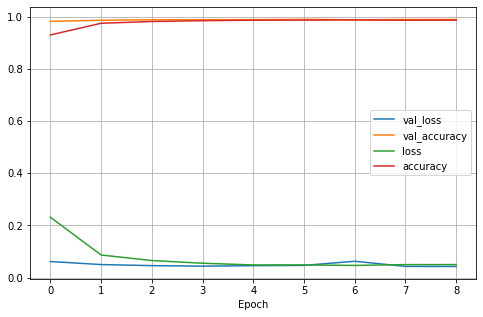

Train acc:0.999; Valid acc: 0.981


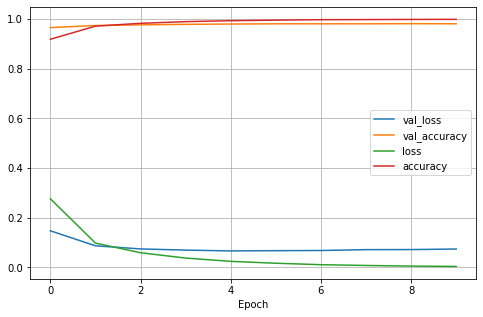

Train acc:0.997; Valid acc: 0.992


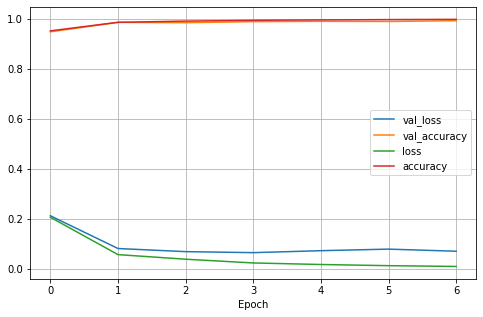

In [0]:
print('Digit data:') 
model_list_digit = [ 
    # base models
    mlp(X_train1, y_train1, epochs= 9),
    cnn(X_train1, y_train1, epochs= 9),
    # selected models  
    mlp_digit(X_train1, y_train1, epochs= 10, lr = 0.0001),
    cnn_digit(X_train1, y_train1, epochs= 7, lr =0.001)]

Fashion data:
Train acc:0.891; Valid acc: 0.875


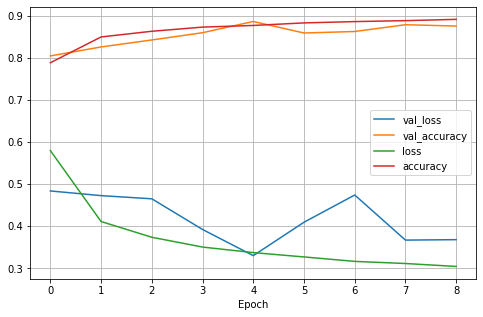

Train acc:0.931; Valid acc: 0.923


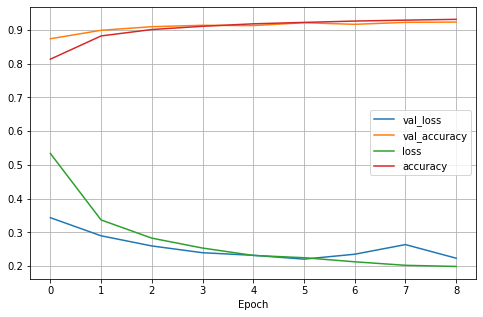

Train acc:0.941; Valid acc: 0.886


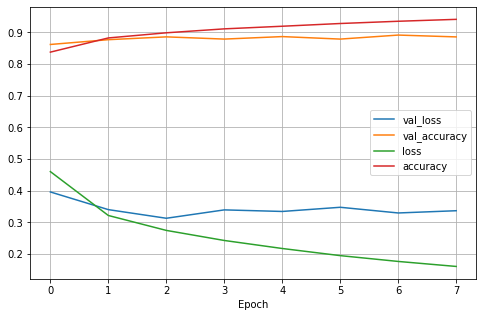

Train acc:0.981; Valid acc: 0.925


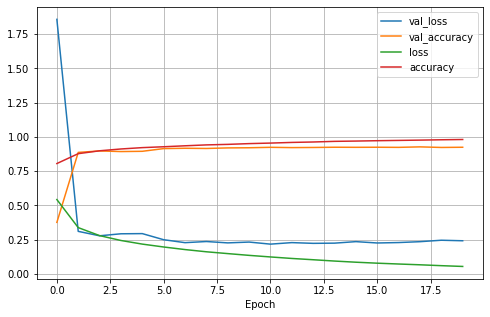

In [0]:
print('Fashion data:') 
model_list_fashion = [ 
    # base models
    mlp(X_train2, y_train2, epochs= 9),
    cnn(X_train2, y_train2, epochs= 9),
    # selected models   
    mlp_fashion(X_train2, y_train2, epochs= 8, lr = 0.0001),
    cnn_fashion(X_train2, y_train2, epochs= 20, lr =0.0001)]

In [0]:
print('Digit data:')
for model in model_list_digit:
     score_test = model.evaluate(X_test1, y_test1, verbose=0)
     print('Test loss:{:.3f}; Test accuracy: {:.3f}'.format(score_test[0], score_test[1]))


print('Fashion data:')
for model in model_list_fashion:
     score_test = model.evaluate(X_test2, y_test2, verbose=0)
     print('Test loss:{:.3f}; Test accuracy: {:.3f}'.format(score_test[0], score_test[1]))

Digit data:
Test loss:0.090; Test accuracy: 0.980
Test loss:0.036; Test accuracy: 0.990
Test loss:0.066; Test accuracy: 0.981
Test loss:0.066; Test accuracy: 0.990
Fashion data:
Test loss:0.393; Test accuracy: 0.869
Test loss:0.239; Test accuracy: 0.918
Test loss:0.380; Test accuracy: 0.877
Test loss:0.271; Test accuracy: 0.921


# Task 2
The second task focuses on the performance difference between MLPs and CNNs. Both digit and fashion data sets are permuting randomly. The new permuted data was trained using the selected models in Task 1. 

First, let us create the permutated dataset

In [0]:
# Create permutated dataset
indices = np.random.permutation(np.arange(784))
data_list = [X_train1,  X_train2,  X_test1,  X_test2]
data_permutated_list = [0,0,0,0]
i = 0
for mat in data_list:
    data_permutated_list[i] = np.array(
    [x.reshape(784, 1)[indices].reshape(28, 28, 1) for x in mat])
    i+=1

Now, we will retrain the models on the permutated data and test them on the test data (also permutated).

Train acc:0.999; Valid acc: 0.982


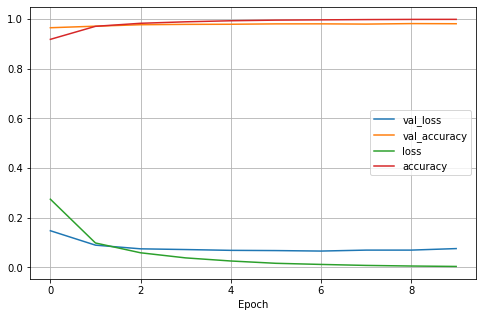

Train acc:0.995; Valid acc: 0.975


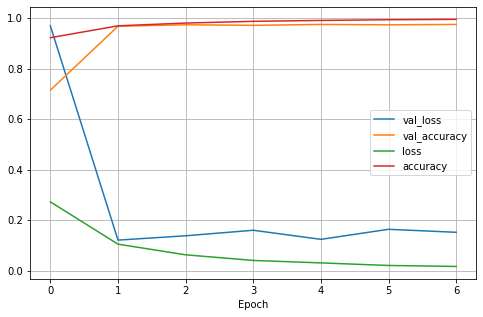

Train acc:0.941; Valid acc: 0.893


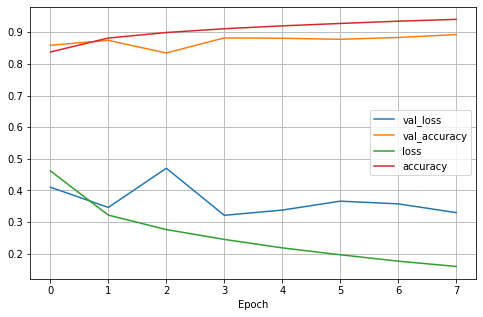

Train acc:0.955; Valid acc: 0.894


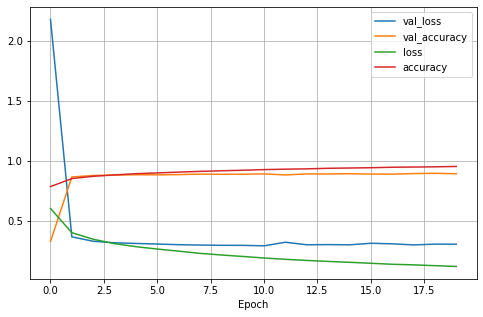

In [0]:
model_list_digit_permutated = [ 
    mlp_digit(data_permutated_list[0], y_train1, epochs= 10, lr = 0.0001),
    cnn_digit(data_permutated_list[0], y_train1, epochs= 7, lr =0.001)]
 
model_list_fashion_permutated = [ 
    mlp_fashion(data_permutated_list[1], y_train2, epochs= 8, lr = 0.0001),
    cnn_fashion(data_permutated_list[1], y_train2, epochs= 20, lr =0.0001)]

In [0]:
print('Digit data:')
for model in model_list_digit_permutated:
     score_test = model.evaluate(data_permutated_list[2], y_test1, verbose=0)
     print('Test loss:{:.3f}; Test accuracy: {:.3f}'.format(score_test[0], score_test[1]))


print('Fashion data:')
for model in model_list_fashion_permutated:
     score_test = model.evaluate(data_permutated_list[3], y_test2, verbose=0)
     print('Test loss:{:.3f}; Test accuracy: {:.3f}'.format(score_test[0], score_test[1]))

Digit data:
Test loss:0.066; Test accuracy: 0.982
Test loss:0.148; Test accuracy: 0.974
Fashion data:
Test loss:0.356; Test accuracy: 0.889
Test loss:0.345; Test accuracy: 0.890


# Reference
* [keras.io](https://keras.io/)
* [Standford Deep Learning Course](https://cs230.stanford.edu/)